In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"combi2k2","key":"a7571c9c172a0c5f9460a4129337f6c3"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d combi2k2/chess-pieces-detection

 92% 15.0M/16.3M [00:00<00:00, 155MB/s]
100% 16.3M/16.3M [00:00<00:00, 150MB/s]


In [ ]:
! unzip chess-pieces-detection.zip

In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import cv2
from PIL import Image

## Setting up device:

In [7]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla K80


## Generating anchor boxes:

In [9]:
fe_size = 400 // 8

ctr_x = np.arange(8, (fe_size + 1) * 8, 8)
ctr_y = np.arange(8, (fe_size + 1) * 8, 8)

In [10]:
# coordinates of the 2500 center points to generate anchor boxes
ctr = np.zeros((fe_size ** 2, 2))

for i in range(len(ctr_x) * len(ctr_y)):
    x = i // len(ctr_y)
    y = i %  len(ctr_y)

    ctr[i, 0] = ctr_x[x] - 4
    ctr[i, 1] = ctr_y[y] - 4

print(ctr.shape)

(2500, 2)


In [11]:
# for each of the 2500 anchors, generate 12 anchor boxes
# 2500 * 9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [4, 8, 16, 32]

sub_sample = 8
anchor_boxes = np.zeros(((fe_size * fe_size * 12), 4))
index = 0

for c in ctr:
    ctr_x = c[0]
    ctr_y = c[1]

    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])

            anchor_boxes[index, 0] = ctr_x - h / 2.
            anchor_boxes[index, 1] = ctr_y - w / 2.
            anchor_boxes[index, 2] = ctr_x + h / 2.
            anchor_boxes[index, 3] = ctr_y + w / 2.
            index += 1

print(anchor_boxes.shape)

(30000, 4)


In [12]:
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] < 400) &
        (anchor_boxes[:, 3] < 400)
)[0]

valid_anchor_boxes = anchor_boxes[index_inside]

print(index_inside.shape)
print(valid_anchor_boxes.shape)

(15280,)
(15280, 4)


## Loading backbone model (VGG16):

In [13]:
# List all the layers of VGG16
model = torchvision.models.vgg16(pretrained = True).to(device)
layer = list(model.features)

for i, fe in enumerate(layer):
    print(f'Feature {i + 1}: {fe}')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Feature 1: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 2: ReLU(inplace=True)
Feature 3: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 4: ReLU(inplace=True)
Feature 5: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Feature 6: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 7: ReLU(inplace=True)
Feature 8: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 9: ReLU(inplace=True)
Feature 10: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Feature 11: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 12: ReLU(inplace=True)
Feature 13: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 14: ReLU(inplace=True)
Feature 15: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Feature 16: ReLU(inplace=True)
Feature 17: MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [14]:
# extract the feature maps of size 50 x 50 (apply MaxPool2d 3 times)
layer = layer[: 23]

# Convert this list into a Sequential module
fe_extractor = nn.Sequential(*layer).to(device)

In [51]:
print(fe_extractor)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [50]:
torch.save(fe_extractor.state_dict(), 'Backbone.model')

## Show an example of input:





(416, 416, 3)


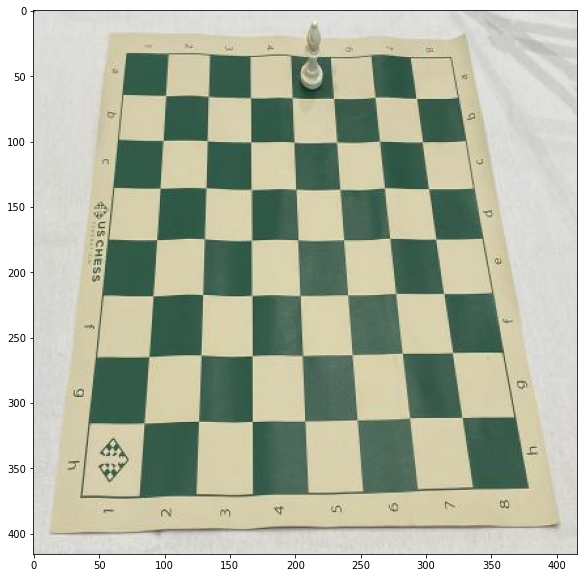

In [15]:
img = cv2.imread('/content/test/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg')
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

img_clone = np.copy(img)

print(img_clone.shape)

plt.figure(figsize = (10,10))
plt.imshow(img_clone)

In [16]:
MyTransform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize([400, 400])
]) # Defing PyTorch Transform

def Image_Prep(img):
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    return  MyTransform(img)

In [17]:
def calc_iou(boxA, boxB):
    xA1, yA1, xA2, yA2 = boxA
    xB1, yB1, xB2, yB2 = boxB

    area_A = (xA2 - xA1) * (yA2 - yA1)
    area_B = (xB2 - xB1) * (yB2 - yB1)

    inner_x1 = max(xA1, xB1);   inner_x2 = min(xA2, xB2)
    inner_y1 = max(yA1, yB1);   inner_y2 = min(yA2, yB2)

    if (inner_x1 >= inner_x2):  return  0
    if (inner_y1 >= inner_y2):  return  0

    inner_area = (inner_y2 - inner_y1) * (inner_x2 - inner_x1)

    return  inner_area / (area_A + area_B - inner_area)

## Rebalance the label:
Sometimes, there are too many negative labels, so the trained model will be biased. So there are 2 solutions to handle this problem:

- $\textbf{Solution 1}$: Ignore certain number of label (get rid of data)
- $\textbf{Solution 2}$: Make positive labels contribute more to the final loss function.

I did not have enough skills so I choose the 1st approach

In [18]:
def label_balancing(label, num_classes = 2):
    pos_index = np.where(label == 1)[0]
    neg_index = np.where(label == 0)[0]

    n_pos = 0.5 * label.shape[0]
    n_neg = np.sum(label == 1)

    if len(pos_index) > n_pos:  label[np.random.choice(pos_index, size = (len(pos_index) - n_pos), replace = False)] = -1
    if len(neg_index) > n_neg:  label[np.random.choice(neg_index, size = (len(neg_index) - n_neg), replace = False)] = -1

## Calculate the groundtruth locs of proposed regions:

In [19]:
def calc_gt_locs(regions, gt_bbox):
    height = regions[:, 2] - regions[:, 0]
    width  = regions[:, 3] - regions[:, 1]
    ctr_x  = regions[:, 0] + 0.5 * height
    ctr_y  = regions[:, 1] + 0.5 * width

    # groundtruth box which correspond this valid anchor box h, w, cx, cy 
    base_height = gt_bbox[:, 2] - gt_bbox[:, 0]
    base_width  = gt_bbox[:, 3] - gt_bbox[:, 1]
    base_ctr_x  = gt_bbox[:, 0] + 0.5 * base_height
    base_ctr_y  = gt_bbox[:, 1] + 0.5 * base_width

    # valid anchor boxes loc = (y-ya/ha), (x-xa/wa), log(h/ha), log(w/wa)
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps) #make height != 0 by let its minimum value be eps
    width  = np.maximum(width,  eps)

    dx = (base_ctr_x - ctr_x) / width
    dy = (base_ctr_y - ctr_y) / height

    dh = np.log(base_height / height)
    dw = np.log(base_width  / width)

    return  np.vstack((dx, dy, dh, dw)).transpose()

In [20]:
def Annotations_Prep(bbox):
    bbox = np.array(bbox)
    ious = np.zeros((len(valid_anchor_boxes), len(bbox)))
    
    for index in range(valid_anchor_boxes.shape[0] * bbox.shape[0]):
        i = index // bbox.shape[0]
        j = index  % bbox.shape[0]

        ious[i, j] = calc_iou(valid_anchor_boxes[i], bbox[j])

    gt_max_ious = ious.max(axis = 0)
    gt_argmax_ious = np.where(ious == gt_max_ious)[0]
    
    argmax_ious = ious.argmax(axis = 1)
    max_ious = ious[np.arange(len(index_inside)), argmax_ious]

    """
    15280 valid anchor boxes with label:
    1: human
    0: background
    -1: ignored
    """
    label = np.empty((len(index_inside), ), dtype = np.int32)
    label.fill(-1)
    
    # Use iou to assign 1 (objects) to two kind of anchors 
    # a) The anchors with the highest iou overlap with a ground-truth-box
    # - An anchor that has an IoU overlap higher than 0.7 with ground-truth box is assigned label "foreground"
    # - An anchor that has an IoU overlap lower  than 0.3 with ground-truth box is assigned label "background"
    pos_iou_threshold = 0.7
    neg_iou_threshold = 0.3
    label[gt_argmax_ious] = 1
    label[max_ious > pos_iou_threshold] = 1
    label[max_ious < neg_iou_threshold] = 0

    label_balancing(label)

    # For each valid anchor box, find the groundtruth object which has max_iou 
    max_iou_bbox = bbox[argmax_ious]

    #calculate the locs of each anchor box
    anchor_locs = calc_gt_locs(valid_anchor_boxes, max_iou_bbox)
        
    anchor_labels = np.empty((len(anchor_boxes),), dtype = label.dtype)
    anchor_labels.fill(-1)
    anchor_labels[index_inside] = label

    anchor_locations = np.zeros(anchor_boxes.shape, dtype = anchor_locs.dtype)
    anchor_locations[index_inside, :] = anchor_locs
    
    return  anchor_labels, anchor_locations

In [21]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Create my own custom dataset:

In [22]:
class ChessDataset(Dataset):
    def __init__(self, base_path):
        super().__init__()
        
        data = None
        
        with open(f'{base_path}/_annotations.coco.json', 'r') as f:
            data = json.load(f)
        
        images = data["images"]
        bboxes = data["annotations"]
        
        pic_names = ["" for i in range(len(images))]
        pic_boxes = [[] for i in range(len(images))]
        
        H_ratio = 400/416.
        W_ratio = 400/416.
        
        for img in images:  pic_names[img["id"]] = img["file_name"]
        for box in bboxes:
            pic_name = box["image_id"]
            box_locs = box["bbox"]
            
            x1, y1, h, w = box_locs
            x2 = x1 + h
            y2 = y1 + w
            
            x1 = x1 * H_ratio;  y1 = y1 * W_ratio
            x2 = x2 * H_ratio;  y2 = y2 * W_ratio
            
            pic_boxes[pic_name].append((x1, y1, x2, y2))
            
        self.images = [cv2.imread(f'{base_path}/{name}') for name in pic_names]
        self.bboxes = pic_boxes

        self.n_samples = len(images)
    
    def __getitem__(self, index):
        image  = self.images[index]
        target = self.bboxes[index]

        return  Image_Prep(image), Annotations_Prep(target)
    
    def __len__(self):
        return  self.n_samples

### Setting up dataset:

In [23]:
train_ds = ChessDataset('/content/train')
valid_ds = ChessDataset('/content/valid')
test_ds = ChessDataset('/content/test')

### Setting up hyper parameters:

In [24]:
num_epochs = 10
batch_size = 10
learning_rate = 0.005

In [25]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
test_dl  = DataLoader(test_ds,  batch_size, shuffle = True, num_workers = 2, pin_memory = True)

In [26]:
n_anchor = 12 # number of anchor boxes having the center being the current point

class RPN_layer(nn.Module):
    def __init__(self):
        super().__init__()
        inp_channels = 512
        mid_channels = 512
        
        self.conv1 = nn.Conv2d(inp_channels, mid_channels, 3, 1, 1)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()

        self.reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()

        self.cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0) ## I will use softmax here. you can equally use sigmoid if u replace 2 with 1.
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
    
    def forward(self, x):
        x = self.conv1(x)
        
        pred_anchor_locs  = self.reg_layer(x)
        pred_anchor_label = self.cls_layer(x)
        
        return  pred_anchor_locs, pred_anchor_label

### Initialize my Model:

In [27]:
RPN_model = RPN_layer().to(device)
optimizer = torch.optim.SGD(RPN_model.parameters(), lr = learning_rate)

## Start Training Loop:

In [28]:
for epoch in range(num_epochs):
    batch_index = 1
    
    for images, target in train_dl:
        images = images.to(device)
        outmap = fe_extractor(images)

        anchor_label = target[0].to(device).contiguous().view(-1)
        anchor_locs  = target[1].to(device).contiguous().view(-1, 4)
        
        #forward step
        pred_locs, pred_score = RPN_model(outmap)

        pred_locs  = pred_locs.permute(0, 2, 3, 1).contiguous().view(-1, 4)
        pred_score = pred_score.permute(0, 2, 3, 1).contiguous().view(-1, 2)

        pos  = anchor_label > 0
        mask = pos.unsqueeze(1).expand_as(pred_locs)

        pred_locs   = pred_locs[mask]
        anchor_locs = anchor_locs[mask]

        rpn_cls_loss = F.cross_entropy(pred_score, anchor_label.long(), ignore_index = -1)
        rpn_reg_loss = F.smooth_l1_loss(pred_locs, anchor_locs)

        rpn_total_loss = rpn_cls_loss + 5. * rpn_reg_loss
        
        optimizer.zero_grad(); rpn_total_loss.backward()
        optimizer.step()

        if (batch_index % 10 == 0):
            print(f'Epoch {epoch + 1}/{num_epochs}, batch {batch_index}: train_loss = {rpn_total_loss}')
        
        batch_index += 1

Epoch 1/10, batch 10: train_loss = 0.6777224982394547
Epoch 1/10, batch 20: train_loss = 0.6041684385027322
Epoch 1/10, batch 30: train_loss = 0.5775912152804084
Epoch 1/10, batch 40: train_loss = 0.4926835397856414
Epoch 1/10, batch 50: train_loss = 0.4937951422008025
Epoch 1/10, batch 60: train_loss = 0.4825097999840429
Epoch 2/10, batch 10: train_loss = 0.5348708459856715
Epoch 2/10, batch 20: train_loss = 0.4443804999798989
Epoch 2/10, batch 30: train_loss = 0.4388193664767631
Epoch 2/10, batch 40: train_loss = 0.4557224139099017
Epoch 2/10, batch 50: train_loss = 0.4027604322963623
Epoch 2/10, batch 60: train_loss = 0.41707850743415104
Epoch 3/10, batch 10: train_loss = 0.3299323263016976
Epoch 3/10, batch 20: train_loss = 0.47756304217302903
Epoch 3/10, batch 30: train_loss = 0.46916262912358353
Epoch 3/10, batch 40: train_loss = 0.36929450155016064
Epoch 3/10, batch 50: train_loss = 0.4083578763550244
Epoch 3/10, batch 60: train_loss = 0.39908661226232983
Epoch 4/10, batch 10: t

In [29]:
torch.save(RPN_model.state_dict(), 'My_RPN.model')

In [31]:
from google.colab import files
files.download('My_RPN.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width  = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width

In [33]:
RPN_model = RPN_layer().to(device)
RPN_model.load_state_dict(torch.load('My_RPN.model', map_location = torch.device(device)))

<All keys matched successfully>

In [34]:
def Proposed_Regions(pred_anchor_locs_numpy, pred_anchor_score_numpy):
    # The 30000 anchor boxes location and labels predicted by RPN (convert to numpy)
    # format = (dy, dx, dh, dw)
    dx = pred_anchor_locs_numpy[:, 0::4] # dx
    dy = pred_anchor_locs_numpy[:, 1::4] # dy
    dh = pred_anchor_locs_numpy[:, 2::4] # dw
    dw = pred_anchor_locs_numpy[:, 3::4] # dh
    
    # ctr_x = dx predicted by RPN * anchor_h + anchor_cx
    # ctr_y similar
    # h = exp(dh predicted by RPN) * anchor_h
    # w similar
    ctr_x = dx * anc_height[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    ctr_y = dy * anc_width[:, np.newaxis]  + anc_ctr_y[:, np.newaxis]
    
    h = np.exp(dh) * anc_height[:, np.newaxis]
    w = np.exp(dw) * anc_width[:, np.newaxis]

    # the final locations of the predicted bounding boxes have the form (x1, y1, x2, y2)
    roi = np.zeros(pred_anchor_locs_numpy.shape, dtype = pred_anchor_locs_numpy.dtype)
    roi[:, 0::4] = ctr_x - 0.5 * h
    roi[:, 1::4] = ctr_y - 0.5 * w
    roi[:, 2::4] = ctr_x + 0.5 * h
    roi[:, 3::4] = ctr_y + 0.5 * w

    # trim the boxes which cover the area outside of the image
    roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, 400)
    roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, 400)

    return  roi

## Use Non-Maxima Suppression:

- Send $30000$ RoIs prdicted by RPN to Fast RCNN to predict bbox + classifications
- Reduce $30000$ RoIs to $2000$

In [35]:
nms_thresh = 0.7  # non-maximum supression (NMS)
min_size   = 8

In [36]:
def NMS_filter(pred_locs, pred_score):
    pred_locs  = pred_locs.permute(0, 2, 3, 1).contiguous().view(-1, 4)
    pred_score = pred_score.permute(0, 2, 3, 1).contiguous().view(-1, 2)

    pred_anchor_locs_numpy  = pred_locs.cpu().data.numpy()
    pred_anchor_score_numpy = pred_score.cpu().data.numpy()[:, 1]

    roi = Proposed_Regions(pred_anchor_locs_numpy, pred_anchor_score_numpy)

    # elimiate proposed boxes which are too small
    hs = roi[:, 2] - roi[:, 0]
    ws = roi[:, 3] - roi[:, 1]

    keep = np.where((hs >= min_size) & 
                    (ws >= min_size))[0]
    
    roi = roi[keep]

    # start NMS filter
    score = pred_anchor_score_numpy[keep]
    order = score.ravel().argsort()[::-1]
    
    order = order[:500]
    roi = roi[order, :]

    # Take all the roi boxes [roi_array]
    x1 = roi[:, 0]; y1 = roi[:, 1]
    x2 = roi[:, 2]; y2 = roi[:, 3]

    # Find the areas of all the boxes [roi_area]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    #Take the indexes of order the probability score in descending order 
    order = order.argsort()[::-1]
    keep = []

    while (order.size > 0):
        i = order[0] #take the 1st elt in order and append to keep 
        keep.append(i)

        inner_x1 = np.maximum(x1[i], x1[order[1:]])
        inner_y1 = np.maximum(y1[i], y1[order[1:]])
        inner_x2 = np.minimum(x2[i], x2[order[1:]])
        inner_y2 = np.minimum(y2[i], y2[order[1:]])

        inner_h = np.maximum(0.0, inner_x2 - inner_x1 + 1)
        inner_w = np.maximum(0.0, inner_y2 - inner_y1 + 1)

        inter = inner_h * inner_w
        outer = areas[i] + areas[order[1:]] - inter

        ious = inter / outer
        inds = np.where(ious <= nms_thresh)[0]

        order = order[inds + 1]
    
    return  roi[keep]# the final region proposals

### Testing RPN model

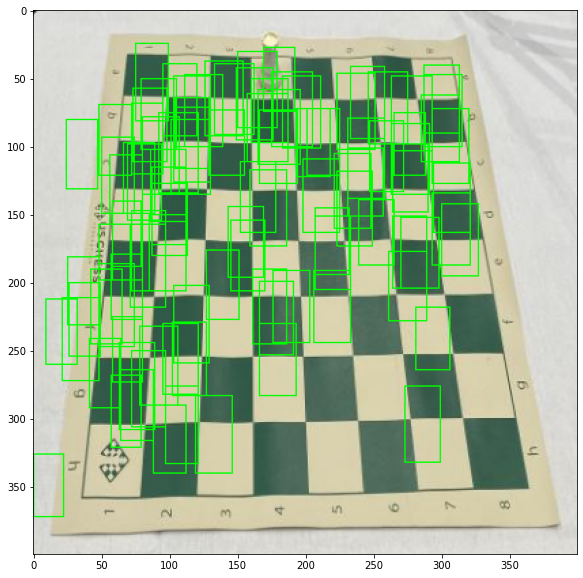

In [42]:
with torch.no_grad():
    img = cv2.imread('/content/test/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.f02cd668d26a53d9bf001497992b3657.jpg')

    # calculate predicted label and locs
    img_clone = Image_Prep(img)
    img_clone = img_clone.unsqueeze(0).to(device)

    outmap = fe_extractor(img_clone)
    pred_locs, pred_score = RPN_model(outmap)

    rois = NMS_filter(pred_locs, pred_score)

    # show the bounding box of predicted boxes:
    img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, dsize = (400, 400), interpolation = cv2.INTER_AREA)

    index = np.arange(rois.shape[0])
    index = np.random.choice(index, size = 100, replace = False)

    rois = rois[index]

    for i in range(rois.shape[0]):
        x1, y1, x2, y2 = rois[i]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize = (10, 10))
plt.imshow(img)

## ROI Pooling
I think I should rewrite my own version of ROI Align Layer

In [43]:
dsize = (10, 10)
adaptive_max_pool = nn.AdaptiveMaxPool2d(*dsize)

In [44]:
class ROI_Dataset(Dataset):
    def __init__(self, pre_Dataset):
        super().__init__()

        self.input  = []
        self.target = []

        for img, bbox in zip(pre_Dataset.images, pre_Dataset.bboxes):
            img = Image_Prep(img)
            img = img.unsqueeze(0).to(device)

            bbox = np.array(bbox)

            with torch.no_grad():
                outmap = fe_extractor(img)
                pred_locs, pred_score = RPN_model(outmap)

                rois = NMS_filter(pred_locs, pred_score)
            
            ious = np.zeros((len(rois), len(bbox)), dtype = np.float32)

            for index in range(len(rois) * len(bbox)):
                i = index // len(bbox)
                j = index  % len(bbox)

                ious[i, j] = calc_iou(rois[i], bbox[j])
                
            gt_assignment = ious.argmax(axis = 1)
            gt_roi_label = np.ones(gt_assignment.shape)

            max_iou = ious.max(axis = 1)

            # assign if the proposed region has a chesspiece or not
            pos_index = np.where(max_iou >= 0.7)[0]
            neg_index = np.where(max_iou <  0.3)[0]
            
            keep_index = np.append(pos_index, neg_index)

            gt_roi_labels = gt_roi_label[keep_index]
            gt_roi_labels[pos_index.size:] = 0  # negative labels --> 0

            label_balancing(gt_roi_labels)

            # calculate the groundtruth locs for proposed regions:
            sample_roi = rois[keep_index]
            bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]

            gt_roi_locs = calc_gt_locs(sample_roi, bbox_for_sampled_roi)

            rois = torch.from_numpy(sample_roi).float()
            rois = rois / 8.0 #Downsampling ratio
            rois = rois.long()

            if (rois.shape[0] != keep_index.shape[0]):
                print("BUG detected")
            
            for i in range(rois.shape[0]):
                x1, y1, x2, y2 = rois[i]
                img = outmap[0][..., x1: x2 + 1, y1: y2 + 1]
                tmp = adaptive_max_pool(img)

                self.input.append(tmp[0])
                self.target.append((gt_roi_labels[i], gt_roi_locs[i]))

        self.n_samples = len(self.input)

    def __getitem__(self, index):
        return  self.input[index], self.target[index]

    def __len__(self):
        return  self.n_samples

In [48]:
print(torch.cuda.memory_summary(device=device, abbreviated=False)) 

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    7544 MB |    7592 MB |   14759 GB |   14752 GB |
|       from large pool |     606 MB |    4646 MB |   14738 GB |   14737 GB |
|       from small pool |    6938 MB |    6939 MB |      21 GB |      15 GB |
|---------------------------------------------------------------------------|
| Active memory         |    7544 MB |    7592 MB |   14759 GB |   14752 GB |
|       from large pool |     606 MB |    4646 MB |   14738 GB |

In [46]:
torch.cuda.empty_cache()

In [ ]:
train_roi_ds = ROI_Dataset(train_ds)
valid_roi_ds = ROI_Dataset(valid_ds)

In [ ]:
outmap, target = train_roi_ds[0]

print(outmap.shape)
print(target)

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(outmap[0][i].data.cpu())

plt.show()

In [ ]:
num_epochs = 10
batch_size = 32
learning_rate = 0.005

In [ ]:
train_roi_dl = DataLoader(train_roi_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_roi_dl = DataLoader(valid_roi_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

### Setting up features for my ROI Classifier:

In [ ]:
class ROI_Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(10 * 10 * 512, 4096)

        self.reg_layer = nn.Linear(4096, 4)
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()    

        self.cls_layer = nn.Linear(4096, 2)
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
         
    def forward(self, x):
        x = x.view(-1)
        x = nn.ReLU(self.fc1(x))

        pred_score = self.cls_layer(x)
        pred_locs  = self.reg_layer(x)

        return  pred_locs, pred_score

In [ ]:
ROI_model = ROI_Classifier().to(device)
optimizer = torch.optim.SGD(ROI_model.parameters(), lr = learning_rate)

In [ ]:
for epoch in range(num_epochs):
    batch_index = 1
    
    for outmap, target in train_roi_dl:
        gt_label = target[0].to(device).contiguous().view(-1)
        gt_locs  = target[1].to(device).contiguous().view(-1, 4)

        #forward step
        pred_locs, pred_score = ROI_model(outmap.to(device))

        pos  = gt_label > 0
        mask = pos.unsqueeze(1).expand_as(pred_locs)

        pred_locs = pred_locs[mask]
        gt_locs   = gt_locs[mask]

        roi_cls_loss = F.cross_entropy(pred_score, gt_label.long(), ignore_index = -1)
        roi_reg_loss = F.smooth_l1_loss(pred_locs, gt_locs)

        roi_total_loss = roi_cls_loss + 5. * roi_reg_loss
        
        optimizer.zero_grad(); roi_total_loss.backward()
        optimizer.step()

        if (batch_index % 20 == 0):
            print(f'Epoch {epoch + 1}/{num_epochs}, batch {batch_index}: train_loss = {roi_total_loss}')
        
        batch_index += 1